# Latency Variation Results 

These results plot the simulation metrics against an X axis of increaing latency variation both in terms of mean and standard deviation of the single message latency. 

## Multiple Results Analysis

This notebook is intended to read a simulation results file with multiple simulations and results and create aggregate analyses and visualizations.

**Goal**:

1. Raft doesn't commit forks 
2. Raft accepts first seen 
3. Eventual chooses raft then latest

**Experimental control variables:**

- _increasing WAN latency, e.g. T (tick)_
- increasing number of nodes
- increasing amounts of failure

**Metrics:**

- number of forks
- number of stale reads
- percent visible (for full replication)
- percent committed
- number of messages
- read latency
- write latency
- visibility latency
- commit latency

In [1]:
%load_ext memory_profiler
%matplotlib inline

import os
import sys 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import graph_tool.all as gt
import matplotlib.pyplot as plt

from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.colors import ColorMap
from cloudscope.results import Results
from cloudscope.results.graph import extract_graph
from cloudscope.results.analysis import create_per_replica_dataframe as create_replica_dataframe
from cloudscope.results.analysis import create_per_experiment_dataframe as create_dataframe

In [2]:
sns.set_style('whitegrid')
sns.set_context('poster')
sns.set_palette('Paired')

In [3]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures", "results")

FIGURES  = os.path.join("..", "fixtures", "figures", "latency-variation")
RESULTS  = os.path.join(FIXTURES, "federated-latency-2016100910.json")
extra    = os.path.join(FIXTURES, "federated-latency-noagg-raft.json")

def get_results_data(*paths):
    for path in paths:
        with open(path, 'r') as f:
            for line in f:
                yield Results.load(line)

In [4]:
%%memit 
df = create_dataframe(get_results_data(RESULTS))

peak memory: 4452.61 MiB, increment: 4324.74 MiB


In [5]:
# Rescale the experiments by saying that 1 ms actually = 0.5 ms 
rescale_columns = [
    'anti-entropy delay (ms)', 
    'cumulative read time staleness (ms)',
    'cumulative write time staleness (ms)',
    'election timeout (ms, ms)',
    'heartbeat interval (ms)',
    'latency range (ms)',
    'mean commit latency (ms)',
    'mean dropped write latency (ms)',
    'mean latency (ms)',
    'mean partial visibility latency (ms)',
    'mean read latency (ms)',
    'mean read time staleness (ms)',
    'mean visibility latency (ms)',
    'mean write latency (ms)',
    'mean write time staleness (ms)',
    'simulation time (secs)',
    'standard deviation of latency (ms)',
    'tick metric (T)',
]

def rescale(num):
    if isinstance(num, list):
        return map(rescale, num)

    return float(num) / 2.0 

for rc in rescale_columns: 
    df[rc] = df[rc].apply(rescale)

In [6]:
# Save or load data from CSV rather than results objects. 
CSV_RESULTS = os.path.join(FIXTURES, "federated-latency.csv")

# Save the results to disk 
df.to_csv(CSV_RESULTS)

# Load the results from disk 
# df = pd.read_csv(CSV_RESULTS)

In [7]:
# Uncomment below if you need to see the columns
# print("\n".join(df.columns))

# Add the ename to identify the experiment
df['ename'] = "T = " + df['tick metric (T)'].apply(str) + " " + df['T parameter model']
df['type']  = df['type'].apply(lambda s: s.title())

In [8]:
df = df.sort_values(['type'])

peak memory: 646.62 MiB, increment: 59.50 MiB


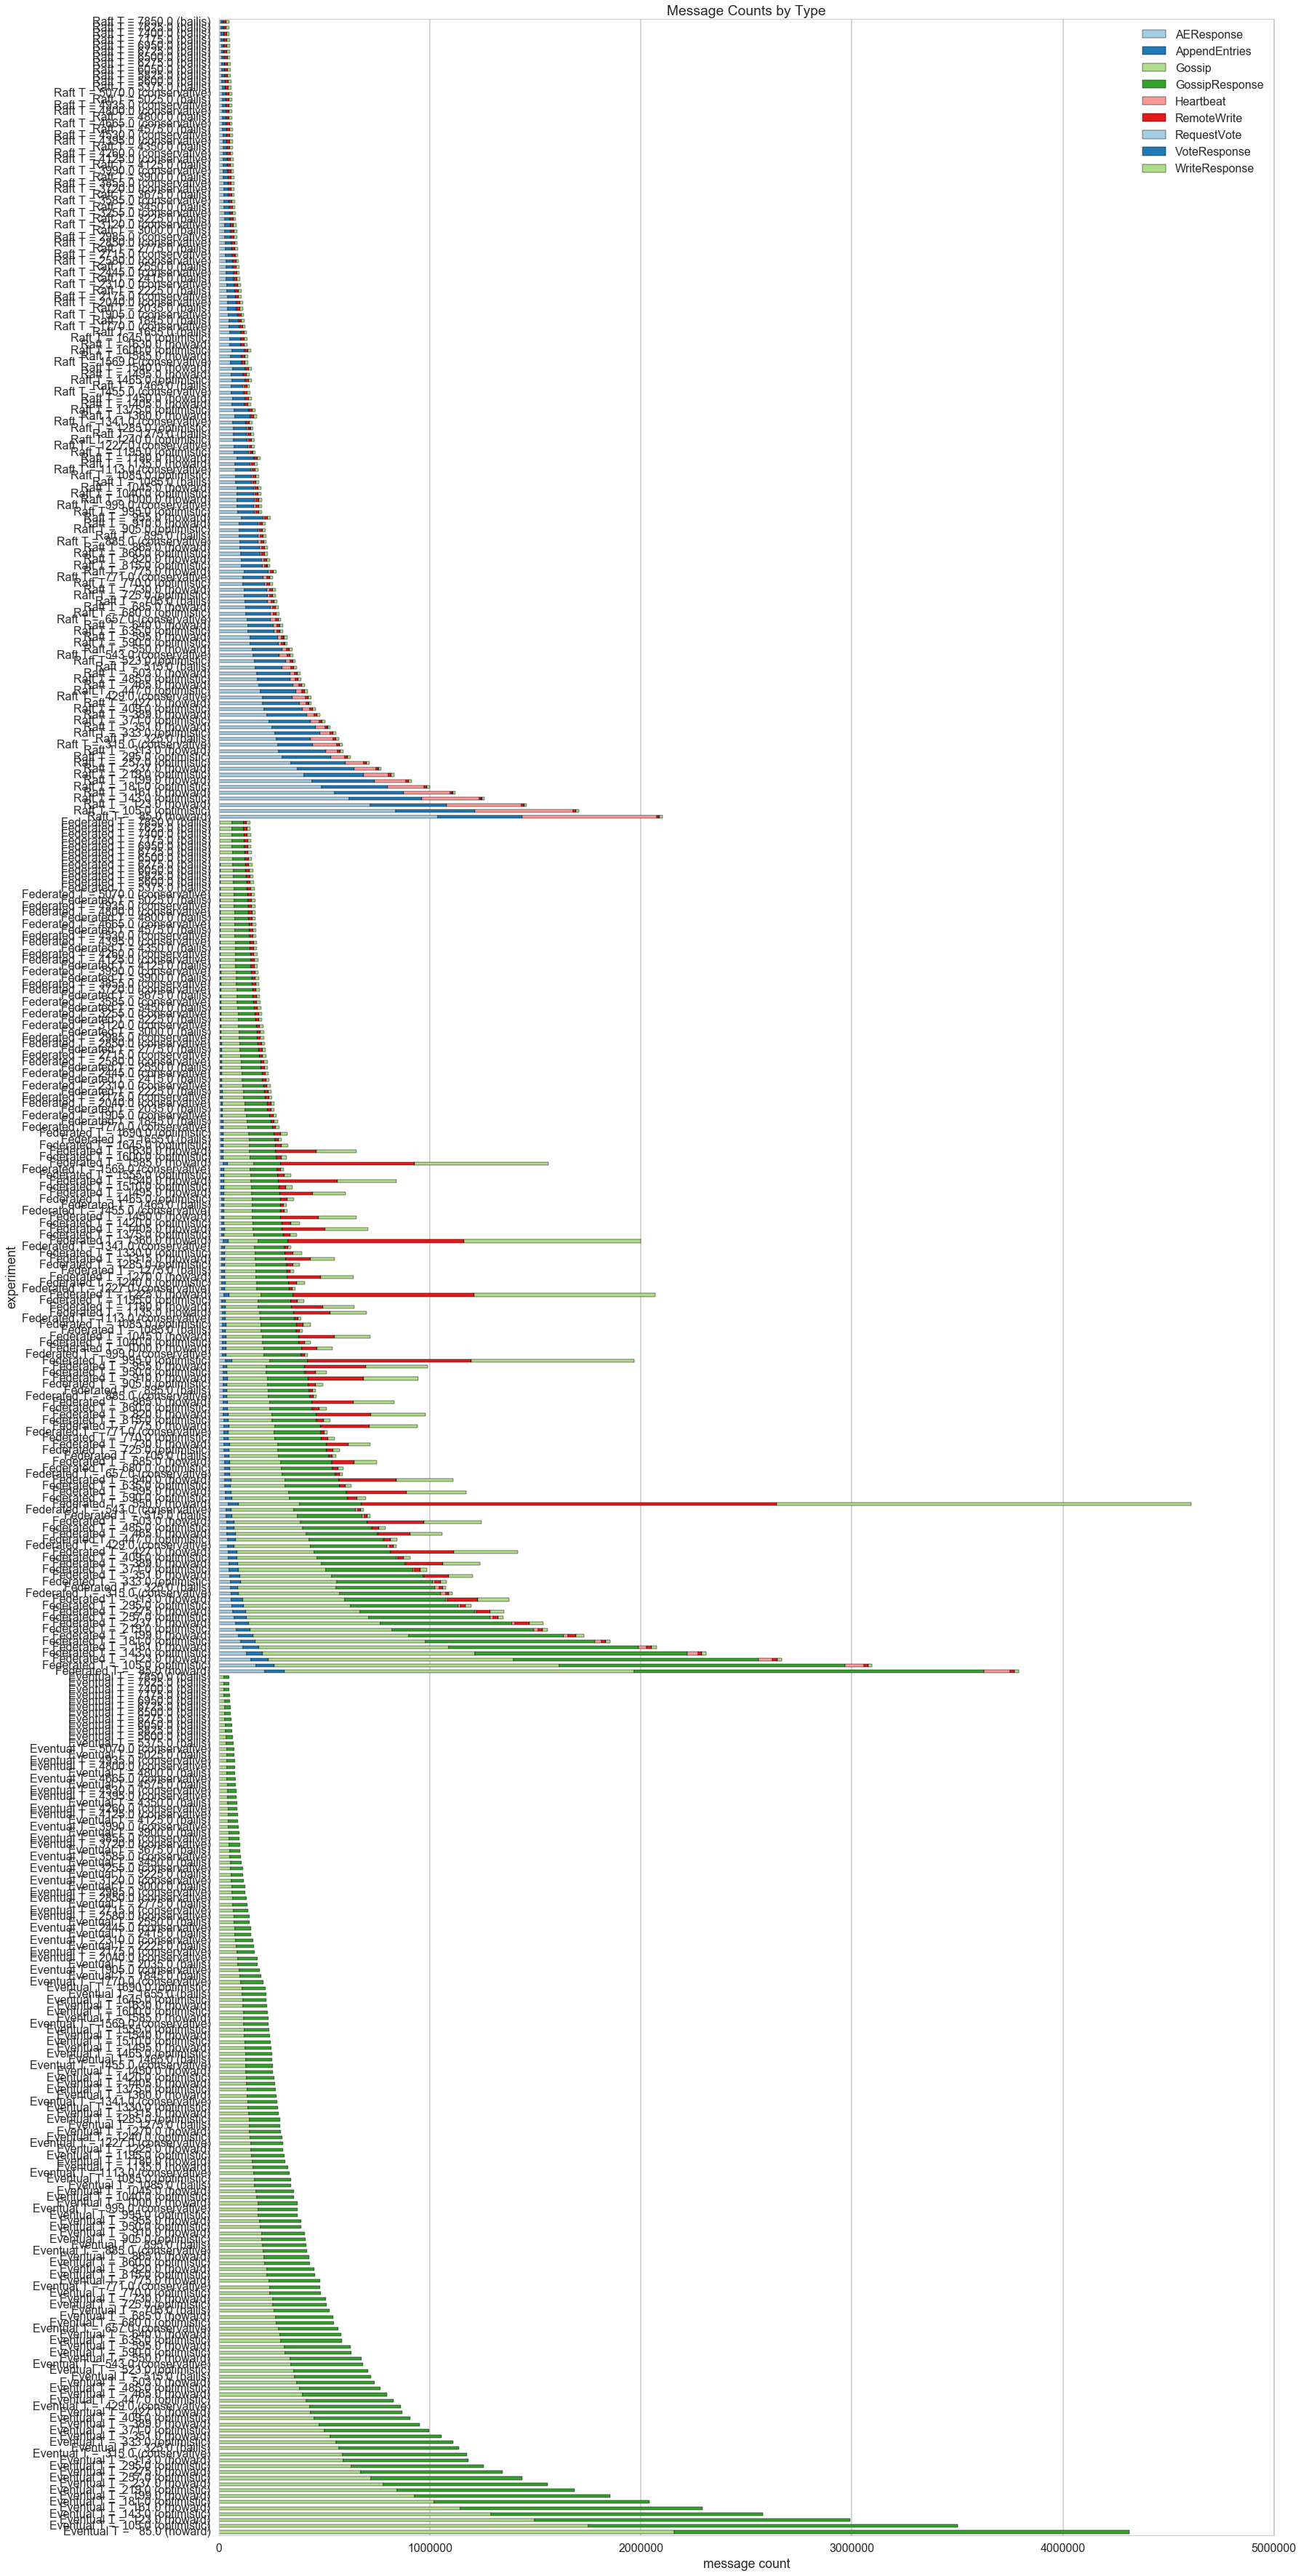

In [9]:
%%memit

def get_message_rows(df):
    for row in df[['message types', 'type', 'tick metric (T)', 'T parameter model',]].itertuples(): 
        item = row[1]
        item['experiment'] = "{} T = {: >6} ({})".format(row[2], row[3], row[4])
        yield item

# Create the data frame 
msgs = pd.DataFrame(sorted(get_message_rows(df), key=lambda item: item['experiment']))

# Create the figure 
fig = plt.figure(figsize=(26,62))
ax  = fig.add_subplot(111)
mpl.rcParams.update({'font.size': 22})

# Plot the bar chart 
g = msgs.plot(
    x='experiment', kind='barh', stacked=True, ax=ax, 
    title="Message Counts by Type", color=sns.color_palette()
)

# Modify the figure 
ax.set_xlabel("message count")
ax.yaxis.grid(False)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'message_counts.pdf'))

In [10]:
# Filter the dataframe. 
# df = df[(df["T parameter model"] == "conservative") | (df["T parameter model"] == "optimistic")]
df = df[(df["T parameter model"] == "conservative") & (df["mean latency (ms)"] <= 500)]

In [13]:
# markers=["x","x", "D", "D", "o", "o"]
# palette=palette
# markers=["x", "D", "o", "H"]
# palette=["#e31a1c", "#33a02c", "#1f78b4", "#6a3d9a"]
markers=["x", "D", "o"]
palette=["#e31a1c", "#33a02c", "#1f78b4",]

## Results Visualization

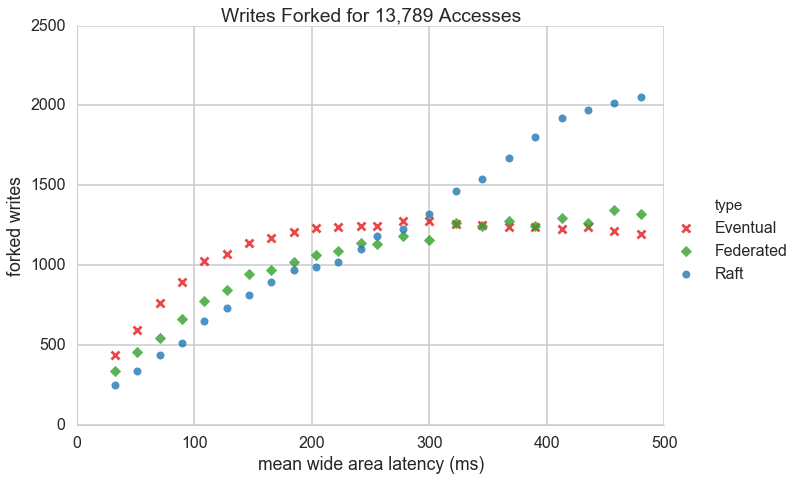

In [15]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
g = sns.lmplot(
    x="mean latency (ms)", y="forked writes", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4, 
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Writes Forked for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'forked_writes.pdf'))

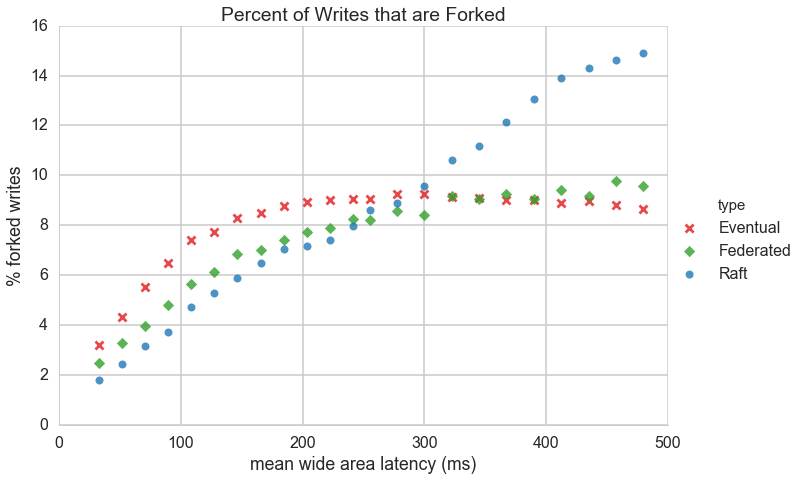

In [16]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
df['% forked writes'] = (df['forked writes'] / df['writes']) * 100

g = sns.lmplot(
    x="mean latency (ms)", y="% forked writes", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4, 
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Percent of Writes that are Forked"
g.ax.set_title(title_fmt)
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'percent_forked_writes.pdf'))

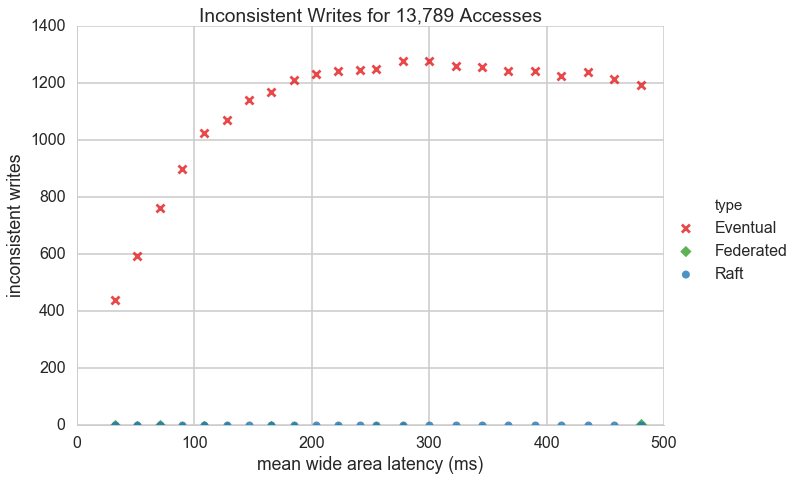

In [17]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
g = sns.lmplot(
    x="mean latency (ms)", y="inconsistent writes", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4,  
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Inconsistent Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'inconsistent_writes.pdf'))

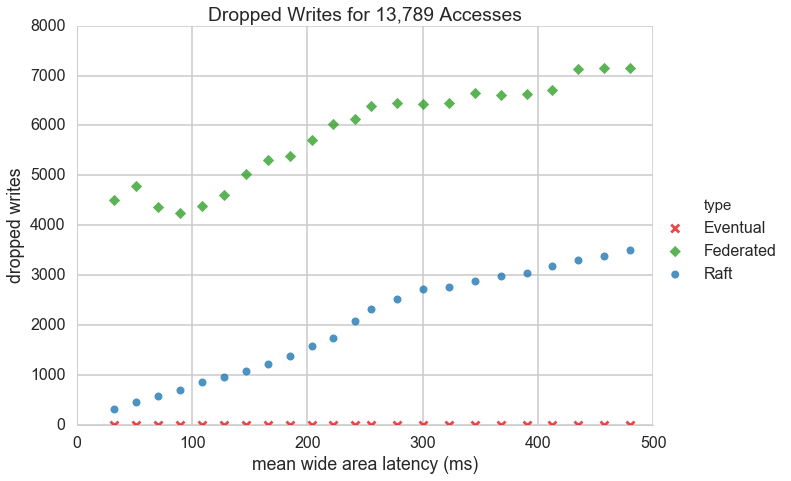

In [18]:
# Dropped Writes
g = sns.lmplot(
    x="mean latency (ms)", y="dropped writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Dropped Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'dropped_writes.pdf'))

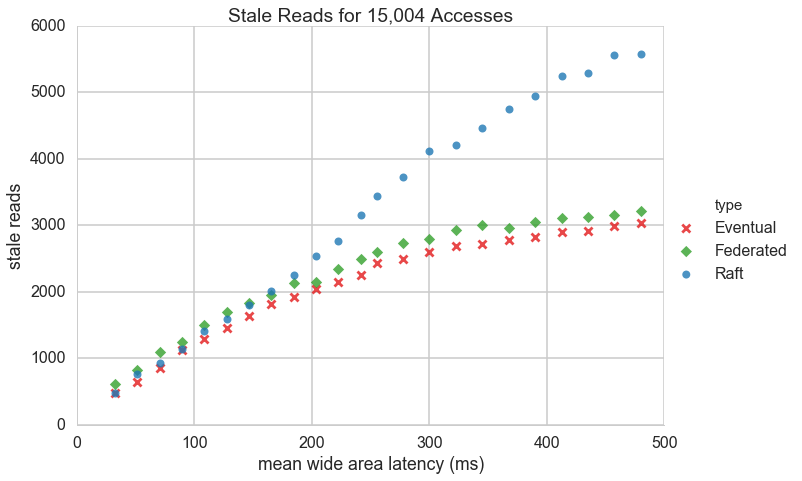

In [19]:
# Stale Reads
g = sns.lmplot(
    x="mean latency (ms)", y="stale reads", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Stale Reads for {:,} Accesses".format(df.reads.max())
g.ax.set_title(title_fmt)
g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0)
    ax[0].set_xlim(0, 500)
    

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'stale_reads.pdf'))

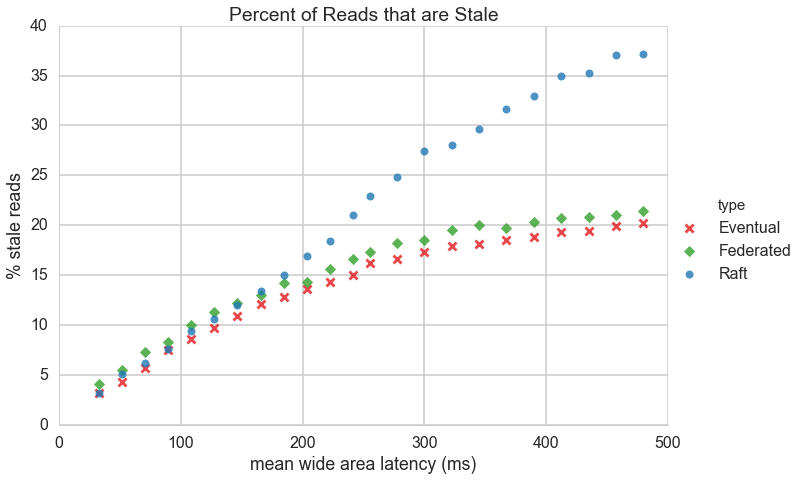

In [20]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
df['% stale reads'] = (df['stale reads'] / df['reads']) * 100

g = sns.lmplot(
    x="mean latency (ms)", y="% stale reads", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4, 
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Percent of Reads that are Stale"
g.ax.set_title(title_fmt)
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'percent_stale_reads.pdf'))

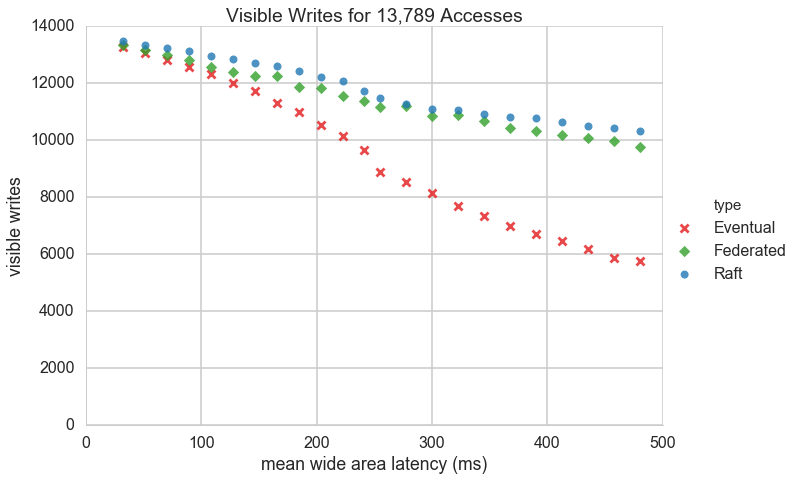

In [21]:
# Visible Writes
g = sns.lmplot(
    x="mean latency (ms)", y="visible writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Visible Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visible_writes.pdf'))

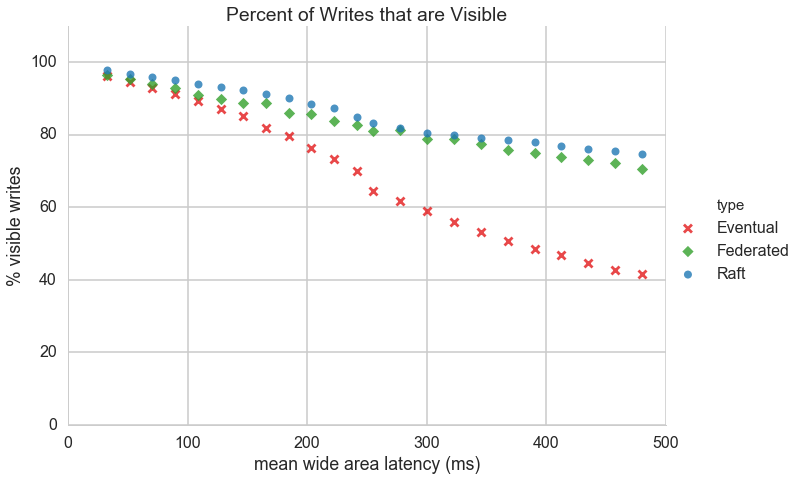

In [22]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
df['% visible writes'] = (df['visible writes'] / df['writes']) * 100

g = sns.lmplot(
    x="mean latency (ms)", y="% visible writes", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4, 
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Percent of Writes that are Visible"
g.ax.set_title(title_fmt)
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'percent_visible_writes.pdf'))

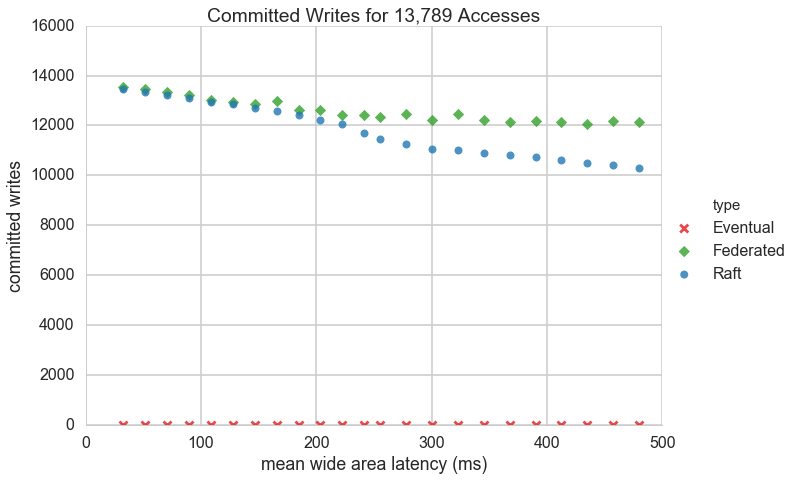

In [23]:
# Comitted Writes
g = sns.lmplot(
    x="mean latency (ms)", y="committed writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Committed Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'committed_writes.pdf'))

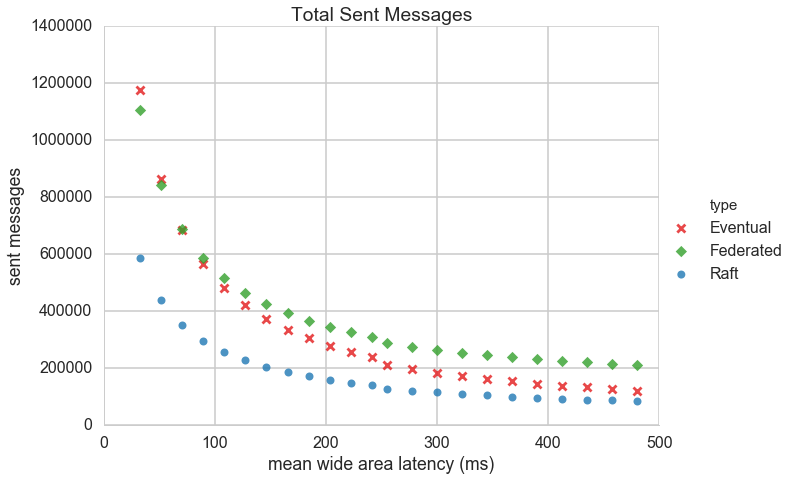

In [24]:
# Number of Messages 
g = sns.lmplot(
    x="mean latency (ms)", y="sent messages", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Total Sent Messages"
g.ax.set_title(title_fmt)
g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'messages_sent.pdf'))

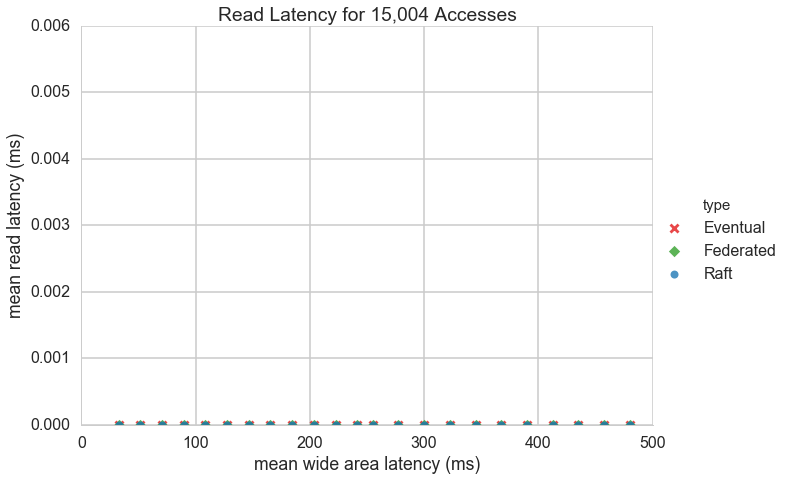

In [25]:
# Read cost (ms delay before read)
g = sns.lmplot(
    x="mean latency (ms)", y="mean read latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, 
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Read Latency for {:,} Accesses".format(df.reads.max())
g.ax.set_title(title_fmt)
g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'read_latency.pdf'))

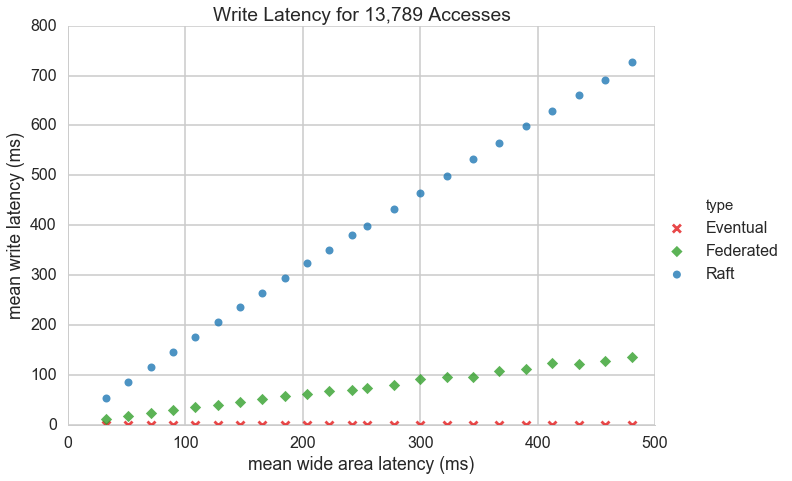

In [26]:
# Write Cost (ms delay before write)
g = sns.lmplot(
    x="mean latency (ms)", y="mean write latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Write Latency for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0)
    ax[0].set_xlim(0, 500)


# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'write_latency.pdf'))

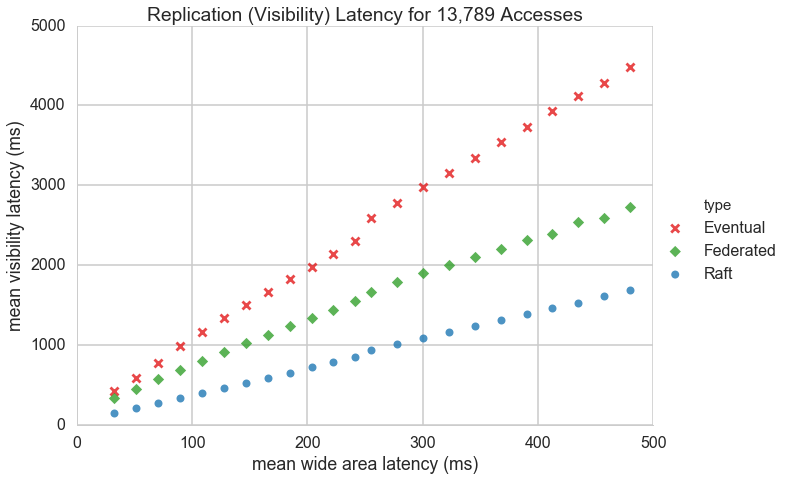

In [27]:
# Replication Cost (Visibility Latency)
g = sns.lmplot(
    x="mean latency (ms)", y="mean visibility latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Replication (Visibility) Latency for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visibility_latency.pdf'))

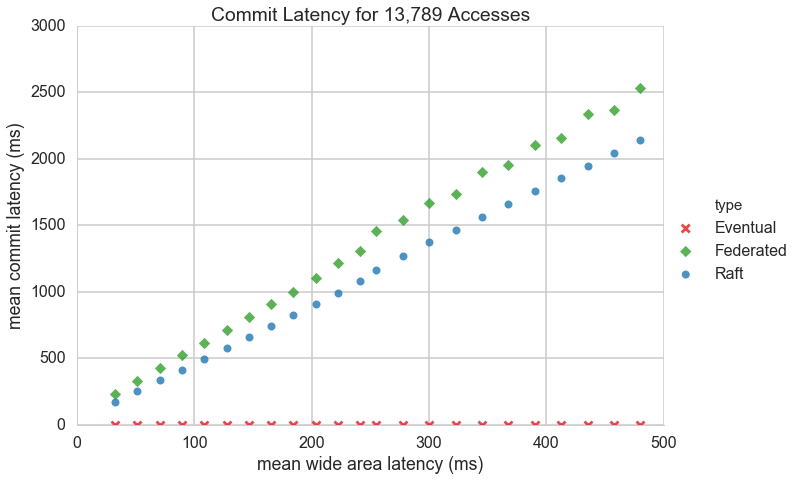

In [28]:
# Commit Cost (Commit Latency)
g = sns.lmplot(
    x="mean latency (ms)", y="mean commit latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  
    palette=palette,
    markers=markers, scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Commit Latency for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'commit_latency.pdf'))

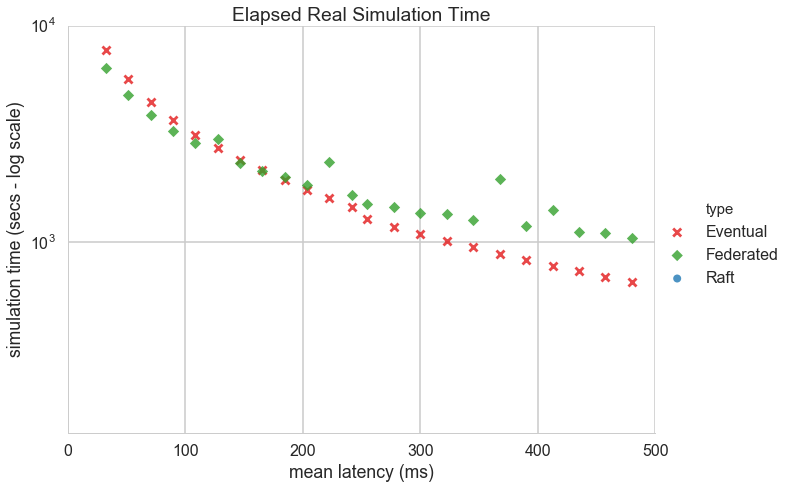

In [29]:
# Simulation Time
g = sns.lmplot(
    x="mean latency (ms)", y="simulation time (secs)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=markers, 
    palette=palette,
    scatter_kws={'s': 64}
)

# Set the title and the labels 
title_fmt = "Elapsed Real Simulation Time"
g.ax.set_title(title_fmt)
g.set(yscale="log")
g.set(ylabel="simulation time (secs - log scale)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0)
    ax[0].set_xlim(0, 500)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'simulation_time.pdf'))

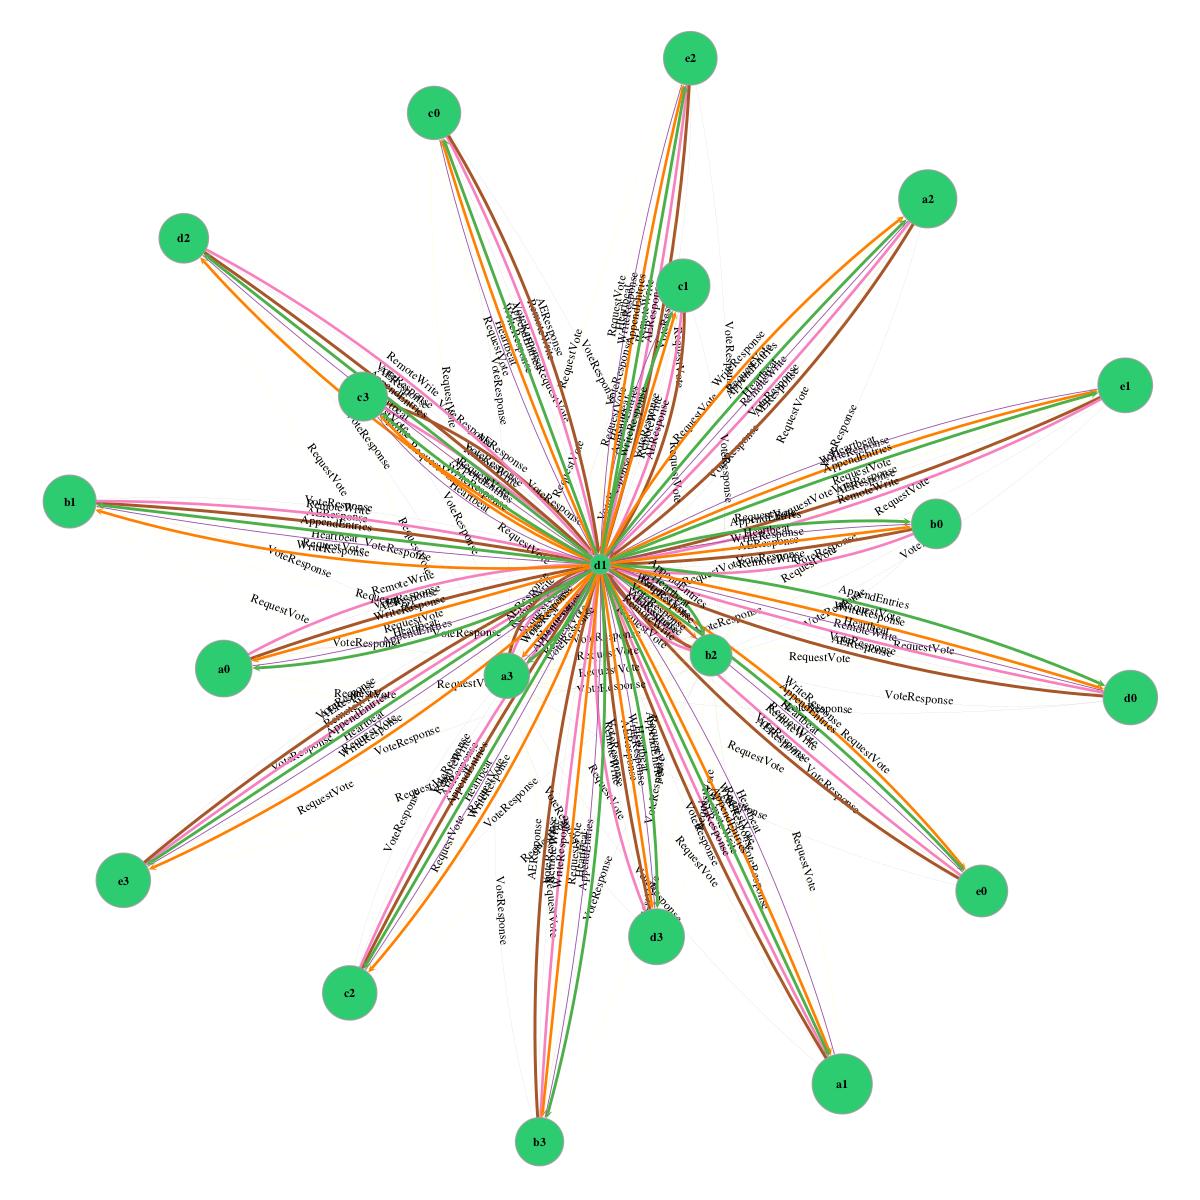

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12d3dd590, at 0x12e43ab10>

In [35]:
def find_results(etype='federated', tick=None):
    for result in get_results_data(RESULTS):
        if result.settings['type'] == etype: 
            if (tick and result.settings['tick_metric'] == tick) or tick is None:
                name = "{}-T{}.pdf".format(etype, tick)
                return result, name    
    return None, None 


# Find the desired results 
result, name = find_results('raft')
if result is None: raise ValueError("Could not find results!")

# Extract the Graph Tool graph     
G = extract_graph(result, by_message_type=True)

# Draw the graph 
vlabel  = G.vp['id']
vsize   = G.vp['writes']
vsize   = gt.prop_to_size(vsize, ma=60, mi=20)

# Set the vertex color 
vcolor  = G.new_vertex_property('string') 
vcmap   = ColorMap('flatui', shuffle=False)
for vertex in G.vertices():
    vcolor[vertex] = vcmap(G.vp['consistency'][vertex])

# Set the edge color 
ecolor  = G.new_edge_property('string')
ecmap   = ColorMap('set1', shuffle=False)
for edge in G.edges():
    ecolor[edge] = ecmap(G.ep['label'][edge])

elabel  = G.ep['label']
esize   = G.ep['norm']
esize   = gt.prop_to_size(esize, mi=.1, ma=3)
eweight = G.ep['weight']

gt.graph_draw(
    G, output_size=(1200,1200), output=os.path.join(FIGURES, name),
    vertex_text=vlabel, vertex_size=vsize, vertex_font_weight=1, 
    vertex_pen_width=1.3, vertex_fill_color=vcolor,
    edge_pen_width=esize, edge_color=ecolor, edge_text=elabel
)